In [3]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

In [4]:
PATH_TO_DATASETS = os.path.join(os.getcwd(), "..", "Datasets")
PATH_TO_DATASETS = os.path.abspath(PATH_TO_DATASETS)

In [ ]:
def display_image_size_distrib(folder, exclude = None):
    widths, heights = [], []
    for root, _, files in os.walk(PATH_TO_DATASETS):
        if exclude is not None:
            if exclude in root:
                continue
        if root.endswith(folder):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    img_path = os.path.join(root, file)
                    try:
                        with Image.open(img_path) as img:
                            w, h = img.size
                            widths.append(w)
                            heights.append(h)
                    except Exception as e:
                        print(f"Error reading {img_path}: {e}")

    plt.figure(figsize=(8, 6))
    plt.scatter(widths, heights, alpha=0.5)
    plt.title(f"Image Sizes in {folder}")
    plt.xlabel("Width (px)")
    plt.ylabel("Height (px)")
    plt.grid(True)
    plt.show()

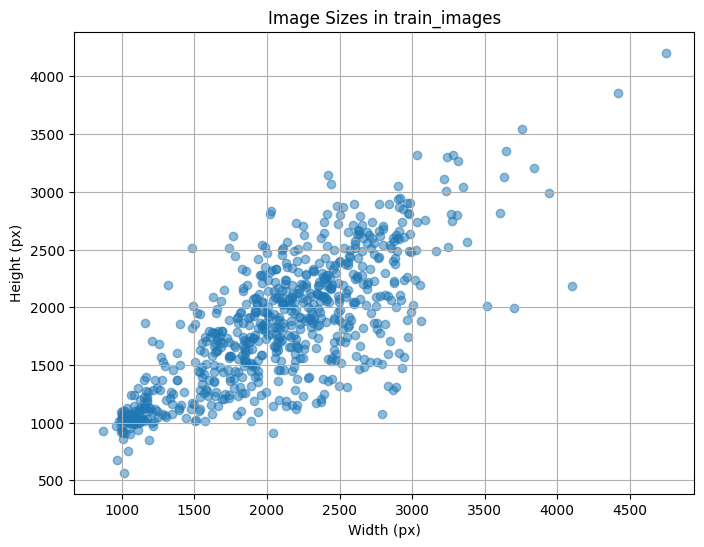

In [13]:
display_image_size_distrib("train_images")

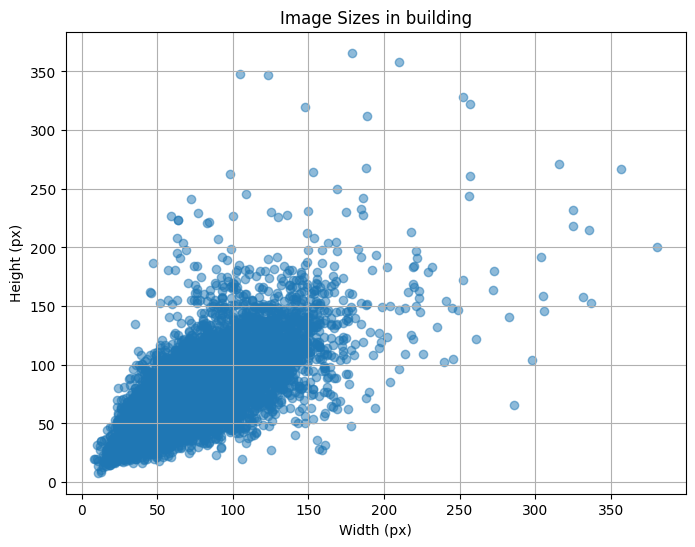

In [15]:
display_image_size_distrib("building", exclude="masks")

In [4]:
def parse_pascal_xml(xml_path):
    root = ET.parse(xml_path).getroot()
    objs = []
    for obj in root.findall('object'):
        name = obj.findtext('name', default='object')
        bnd = obj.find('bndbox')
        if bnd is not None:
            xmin = int(float(bnd.findtext('xmin')))
            ymin = int(float(bnd.findtext('ymin')))
            xmax = int(float(bnd.findtext('xmax')))
            ymax = int(float(bnd.findtext('ymax')))
            objs.append({'type':'bndbox','xmin':xmin,'ymin':ymin,'xmax':xmax,'ymax':ymax,'name':name})
            continue
        poly = obj.find('polygon') or obj.find('segmentation') or obj.find('points')
        if poly is not None:
            pts = []
            for pt in poly.findall('pt'):
                x = int(float(pt.findtext('x'))); y = int(float(pt.findtext('y')))
                pts.append((x,y))
            if not pts:
                xs = [p.text for p in poly.findall('x')]
                ys = [p.text for p in poly.findall('y')]
                if xs and ys and len(xs)==len(ys):
                    pts = [(int(float(x)), int(float(y))) for x,y in zip(xs,ys)]
                else:
                    txt = poly.text
                    if txt:
                        for pair in txt.strip().split():
                            px,py = pair.strip().split(',')
                            pts.append((int(float(px)), int(float(py))))
            if pts:
                objs.append({'type':'polygon','points':pts,'name':name})
                continue
    return objs

def create_mask_for_class(image_size, annots, class_name):
    H, W = image_size
    mask = Image.new('L', (W, H), 0)
    draw = ImageDraw.Draw(mask)
    for a in annots:
        if a.get('name') != class_name:
            continue
        if a['type'] == 'bndbox':
            draw.rectangle([a['xmin'], a['ymin'], a['xmax'], a['ymax']], fill=1)
        elif a['type'] == 'polygon':
            draw.polygon(a['points'], fill=1)
    return np.array(mask, dtype=np.uint8)

def collect_classes_from_xmls(xml_dir):
    classes = set()
    if not os.path.exists(xml_dir):
        return []
    for fname in os.listdir(xml_dir):
        if not fname.lower().endswith('.xml'):
            continue
        xml_path = os.path.join(xml_dir, fname)
        try:
            objs = parse_pascal_xml(xml_path)
        except Exception as e:
            print(f"Warning: failed to parse {xml_path}: {e}")
            continue
        for o in objs:
            classes.add(o.get('name','object'))
    return sorted(classes)

In [5]:
def generate_masks_for_dataset(current_dataset: str, dataset_split_type: str, background_mask: bool = True):
    images_dir = os.path.join(PATH_TO_DATASETS, current_dataset, f"{dataset_split_type}_images")
    xml_dir = os.path.join(PATH_TO_DATASETS, current_dataset, f"{dataset_split_type}_annots")
    masks_out_root = os.path.join(PATH_TO_DATASETS, current_dataset, f"{dataset_split_type}_masks")

    classes = collect_classes_from_xmls(xml_dir)
    for c in classes:
        os.makedirs(os.path.join(masks_out_root, c), exist_ok=True)

    for fname in sorted(os.listdir(images_dir)):
        if not fname.lower().endswith(('.png','.jpg','.jpeg','tif', '.tiff')):
            continue
        base = os.path.splitext(fname)[0]
        img_path = os.path.join(images_dir, fname)
        xml_path = os.path.join(xml_dir, base + '.xml')

        img = Image.open(img_path).convert('RGB')

        W, H = img.size
        annots = parse_pascal_xml(xml_path)

        present_classes = {a['name'] for a in annots if 'name' in a}
        for cls in present_classes:
            mask_np = create_mask_for_class((H, W), annots, cls)
            if mask_np.sum() == 0:
                continue
            if background_mask:
                mask_np = 1 - mask_np
            out_fname = f"{base}.png"
            out_path = os.path.join(masks_out_root, cls, out_fname)
            out_img = (mask_np * 255).astype(np.uint8)
            Image.fromarray(out_img).save(out_path)

    print(f"Masks written to: {masks_out_root}. Classes: {len(classes)}")

In [13]:
generate_masks_for_dataset(current_dataset="UAV 1", dataset_split_type="train", background_mask=True)
generate_masks_for_dataset(current_dataset="UAV 1", dataset_split_type="test", background_mask=True)
generate_masks_for_dataset(current_dataset="UAV 1", dataset_split_type="valid", background_mask=True)

Masks written to: c:\KTU\magistras trecias kursas\grupinis\NesvarbuSefoSpecialus\Datasets\UAV 1\train_masks. Classes: 10
Masks written to: c:\KTU\magistras trecias kursas\grupinis\NesvarbuSefoSpecialus\Datasets\UAV 1\test_masks. Classes: 9
Masks written to: c:\KTU\magistras trecias kursas\grupinis\NesvarbuSefoSpecialus\Datasets\UAV 1\valid_masks. Classes: 10


In [6]:
def generate_crops_for_dataset(current_dataset: str, dataset_split_type: str):
    images_dir = os.path.join(PATH_TO_DATASETS, current_dataset, f"{dataset_split_type}_images")
    xml_dir = os.path.join(PATH_TO_DATASETS, current_dataset, f"{dataset_split_type}_annots")
    crops_out_root = os.path.join(PATH_TO_DATASETS, current_dataset, f"{dataset_split_type}_crops")

    classes = collect_classes_from_xmls(xml_dir)
    for c in classes:
        os.makedirs(os.path.join(crops_out_root, c), exist_ok=True)

    for fname in sorted(os.listdir(images_dir)):
        if not fname.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            continue

        base = os.path.splitext(fname)[0]
        img_path = os.path.join(images_dir, fname)
        xml_path = os.path.join(xml_dir, base + '.xml')

        if not os.path.exists(xml_path):
            print(f"Warning: missing XML for {fname}")
            continue

        try:
            annots = parse_pascal_xml(xml_path)
        except Exception as e:
            print(f"Warning: failed to parse {xml_path}: {e}")
            continue

        img = Image.open(img_path).convert('RGB')
        W, H = img.size

        for i, a in enumerate(annots):
            cls = a.get('name', 'object')

            if a['type'] == 'bndbox':
                xmin = max(0, min(W - 1, a['xmin']))
                ymin = max(0, min(H - 1, a['ymin']))
                xmax = max(0, min(W, a['xmax']))
                ymax = max(0, min(H, a['ymax']))
                if xmax <= xmin or ymax <= ymin:
                    continue
                crop = img.crop((xmin, ymin, xmax, ymax))

            elif a['type'] == 'polygon':
                mask = Image.new('L', img.size, 0)
                pts = [(max(0, min(W - 1, x)), max(0, min(H - 1, y))) for x, y in a['points']]
                ImageDraw.Draw(mask).polygon(pts, outline=1, fill=1)
                crop_box = mask.getbbox()
                if not crop_box:
                    continue
                masked_img = Image.composite(img, Image.new('RGB', img.size, (0, 0, 0)), mask)
                crop = masked_img.crop(crop_box)
            else:
                continue

            out_dir = os.path.join(crops_out_root, cls)
            out_name = f"{base}_{i}.png"
            try:
                crop.save(os.path.join(out_dir, out_name))
            except Exception as e:
                print(f"Warning: failed to save {out_name}: {e}")

    print(f"Cropped objects saved to: {crops_out_root}. Classes: {len(classes)}")


In [7]:
generate_crops_for_dataset(current_dataset="UAV 1", dataset_split_type="train")
generate_crops_for_dataset(current_dataset="UAV 1", dataset_split_type="test")
generate_crops_for_dataset(current_dataset="UAV 1", dataset_split_type="valid")

Cropped objects saved to: c:\KTU\magistras trecias kursas\grupinis\NesvarbuSefoSpecialus\Datasets\UAV 1\train_crops. Classes: 10
Cropped objects saved to: c:\KTU\magistras trecias kursas\grupinis\NesvarbuSefoSpecialus\Datasets\UAV 1\test_crops. Classes: 9
Cropped objects saved to: c:\KTU\magistras trecias kursas\grupinis\NesvarbuSefoSpecialus\Datasets\UAV 1\valid_crops. Classes: 10
